# Real or Fake Prediction - Disaster Tweets

In [4]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np
import re
import string
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
SEED = 666

In [6]:
train_df = pd.read_csv('disaster_tweets/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
test_df = pd.read_csv('disaster_tweets/test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
print('Total training samples: ', train_df.shape)
print('Total testing samples: ', test_df.shape)

Total training samples:  (7613, 5)
Total testing samples:  (3263, 4)


## Keyword & Location

Training & Test sets both have missing values in location & keyword. We analyse them & fill them up with 'no_location' & 'no_keyword' respectively.

In [36]:
print('Percentage of missing KEYWORD values in train: ', round(train_df['keyword'].isna().sum() / train_df.shape[0] * 100, 2))
print('Percentage of missing KEYWORD values in test: ', round(test_df['keyword'].isna().sum() / test_df.shape[0] * 100, 2))

Percentage of missing KEYWORD values in train:  0.8
Percentage of missing KEYWORD values in test:  0.34


In [37]:
print('Percentage of missing LOCATION values in train: ', round(train_df['location'].isna().sum() / train_df.shape[0] * 100, 2))
print('Percentage of missing LOCATION values in test: ', round(test_df['location'].isna().sum() / test_df.shape[0] * 100, 2))

Percentage of missing LOCATION values in train:  33.27
Percentage of missing LOCATION values in test:  33.86


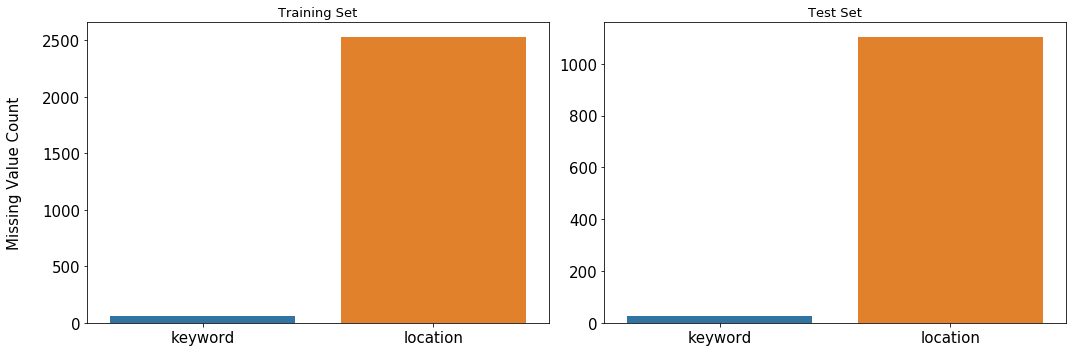

In [40]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

sns.barplot(x=train_df[missing_cols].isna().sum().index, 
            y=train_df[missing_cols].isna().sum().values, ax=axes[0])

sns.barplot(x=test_df[missing_cols].isna().sum().index, 
            y=test_df[missing_cols].isna().sum().values, ax=axes[1])


axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.tight_layout()

In [42]:
for df in [train_df, test_df]:
    for col in missing_cols:
        df[col] = df[col].fillna('no_{}'.format(col))

## Target Distribution

Some keywords in the training set are also present in the testing set. Some keywords can also be used in only one context. 

In [50]:
print('No of unique values in keyword - train: ', train_df['keyword'].nunique())
print('No of unique values in keyword - test: ', test_df['keyword'].nunique())

No of unique values in keyword - train:  222
No of unique values in keyword - test:  222


In [51]:
print('No of unique values in location - train: ', train_df['location'].nunique())
print('No of unique values in location - test: ', test_df['location'].nunique())

No of unique values in location - train:  3342
No of unique values in location - test:  1603


In [59]:
train_df['target_mean'] = train_df.groupby('keyword')['target'].transform('mean')

In [60]:
train_df.head()

,id,keyword,location,text,target,target_mean
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,0.688525
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,0.688525
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,0.688525
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,0.688525
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,0.688525


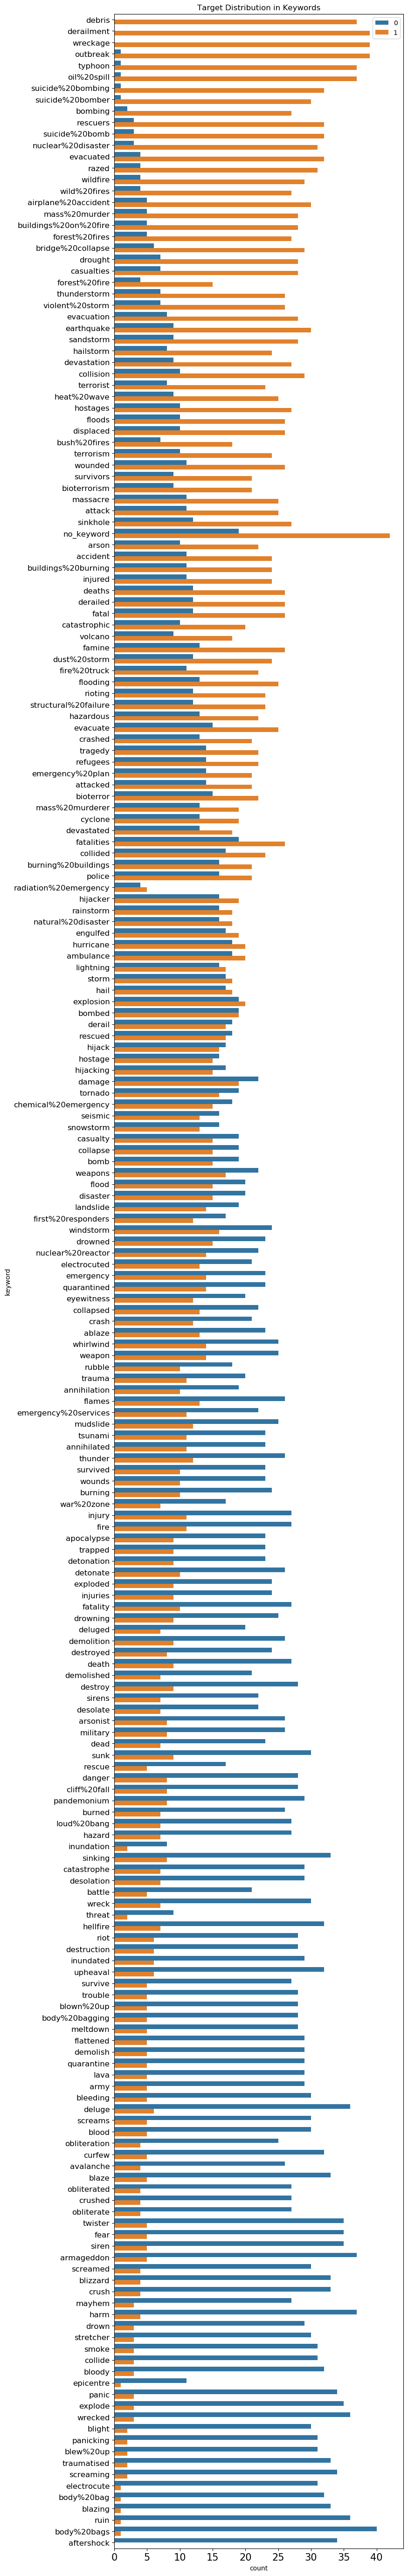

In [62]:
fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train_df.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train_df.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train_df.drop(columns=['target_mean'], inplace=True)

## Meta Features

Disaster tweets come from news agencies with less typos, whereas non-disaster tweets have more typos in them since they are coming from individuals. Disaster tweets are also written in a more formal way, with longer words compared to the other.

In [81]:
## Word Count
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x.split())))
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x.split())))

In [82]:
## Unique word count
train_df['unique_word_count'] = train_df['text'].apply(lambda x: len(set(str(x.split()))))
test_df['unique_word_count'] = test_df['text'].apply(lambda x: len(set(str(x.split()))))

In [83]:
## STOPWORD count
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')

train_df['stopword_count'] = train_df['text'].apply(lambda x: len([i for i in str(x).lower().split() if i not in STOPWORDS]))
test_df['stopword_count'] = test_df['text'].apply(lambda x: len([i for i in str(x).lower().split() if i not in STOPWORDS]))

In [84]:
## URL count
train_df['url_count'] = train_df['text'].apply(lambda x: len([i for i in str(x).lower().split() if 'http' in i or 'https' in i]))
test_df['url_count'] = test_df['text'].apply(lambda x: len([i for i in str(x).lower().split() if 'http' in i or 'https' in i]))

In [91]:
## mean word length
train_df['mean_word_length'] = train_df['text'].apply(lambda x: np.mean([len(i) for i in str(x).split()]))
test_df['mean_word_length'] = test_df['text'].apply(lambda x: np.mean([len(i) for i in str(x).split()]))

In [97]:
## char_count
train_df['character_count'] = train_df['text'].apply(lambda x: len(str(x)))
test_df['character_count'] = test_df['text'].apply(lambda x: len(str(x)))

In [98]:
## punctuation count
train_df['punctuation_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['punctuation_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [99]:
## hashtags count
train_df['hashtag_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_df['hashtag_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

In [100]:
# mention_count
train_df['mention_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_df['mention_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

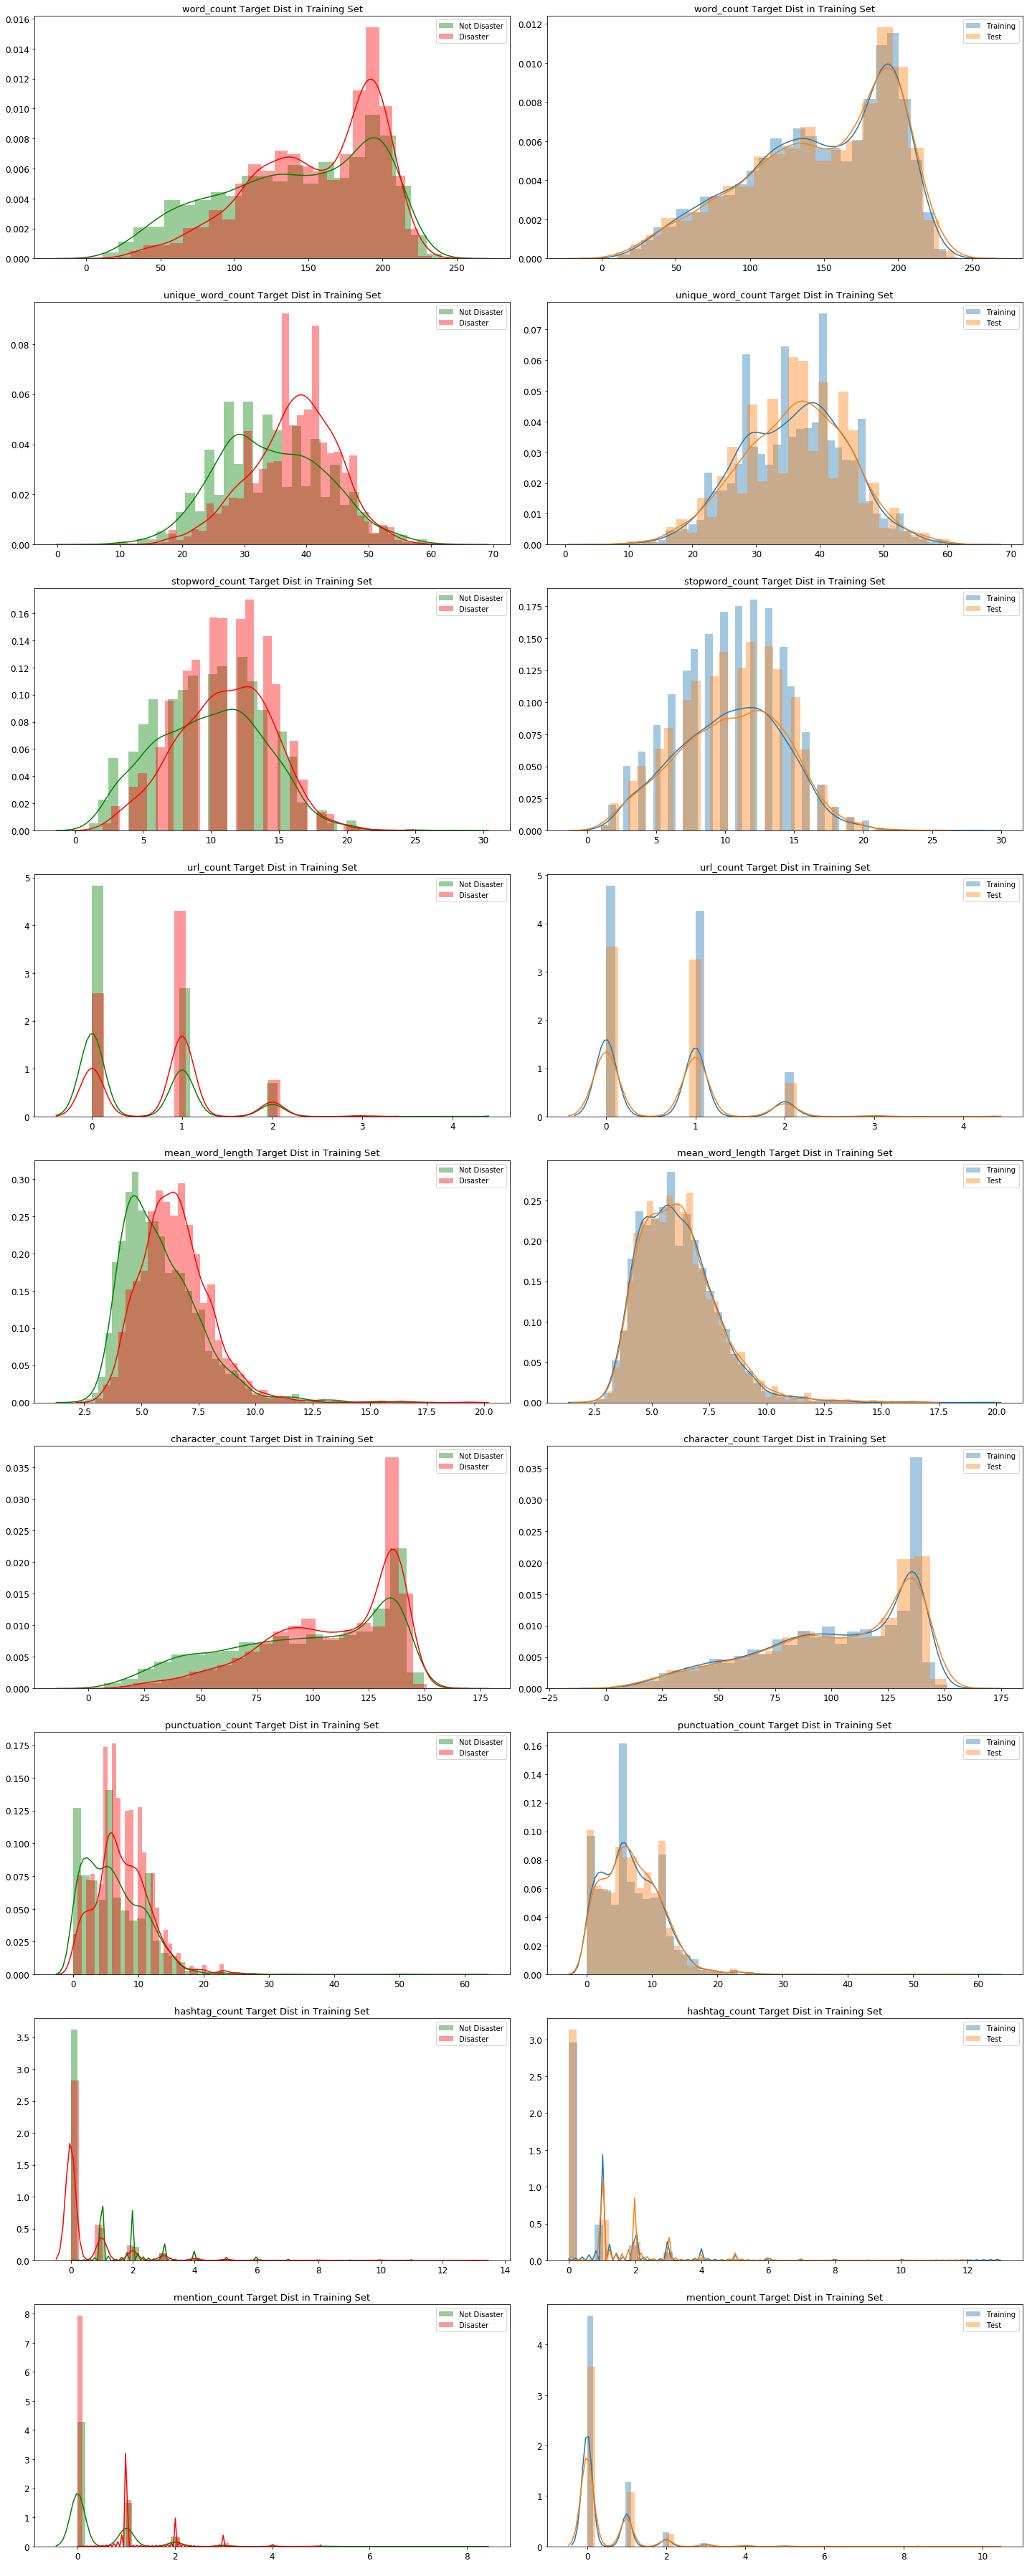

In [105]:
META = ['word_count', 'unique_word_count', 'stopword_count', 'url_count', 'mean_word_length',
        'character_count', 'punctuation_count', 'hashtag_count', 'mention_count']

DISASTER_TWEETS = train_df['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(META), figsize=(20, 50))

for i, feature in enumerate(META):
    sns.distplot(train_df.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train_df.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')
    
    sns.distplot(train_df[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_df[feature], label='Test', ax=axes[i][1])
    
    
    for j in range(2):
        axes[i][j].set_xlabel(' ')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
        
    axes[i][0].set_title('{} Target Dist in Training Set'.format(feature), fontsize=13)
    axes[i][1].set_title('{} Target Dist in Training Set'.format(feature), fontsize=13)
    
    
plt.tight_layout()

## Target &  N-grams

### Target

Checking out the class distribution

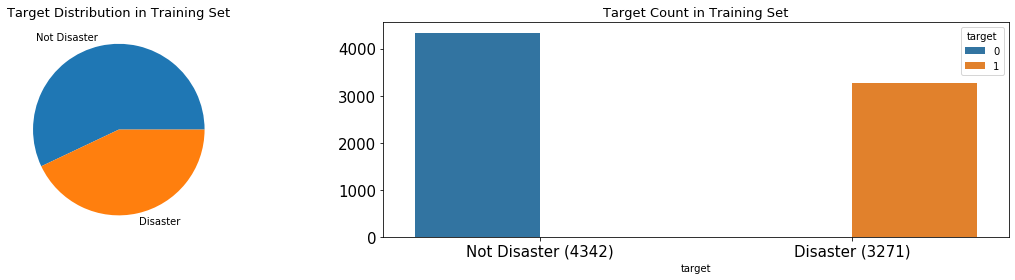

In [113]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4))
train_df.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster', 'Disaster'])
sns.countplot(x=train_df['target'], hue=train_df['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.tight_layout()

In [151]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [154]:
gen_ngrams('have you heard about the bird?')

['heard bird?']

In [159]:
N = 100

disaster_unigrams = defaultdict(int)
nodisaster_unigrams = defaultdict(int)

for tweet in train_df[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in train_df[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nodisaster_unigrams[word] += 1